# 02 :: Distribution Plots

**Objectives:**
* Plot distributions by Region and Age

In [1]:
# %load common.py
import pandas as pd
import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Commonly used constants.

slides = [
    'B02_D1', 'B02_E1', 'B03_C2', 'B03_D2', 'B04_D1',
    'B04_E1', 'B05_D2', 'B05_E2', 'B06_E1', 'B07_C2',
    'N02_C1', 'N02_D1', 'N03_C2', 'N03_D2', 'N04_D1',
    'N04_E1', 'N05_C2', 'N05_D2', 'N06_D2', 'N07_C1']

GT = 'GT'
YEN = 'AB1_StdDev_Yen'
REGION = 'Region_predict'
ASTROCYTE = 'astrocyte'
NEURON = 'neuron'
INTERNEURON = 'interneuron'
AGE = 'age'
DAYS = 'age_days'
MONTHS = 'age_months'
AGE_GT ='age_GT'
SAMPLE_ID = 'sampleID'
SPOT_UID = 'spot_UID'

# The merged data file in Parquet format.

parquet = '/media/tmo/data/work/datasets/02_ST/parquet/'
st_full = parquet + 'st_full'

def read_full(path=st_full):
    return pd.read_parquet(st_full)

def enrich(full):
    # Add age column (young, old)
    full[AGE] = np.where(full[MONTHS] < 10, 'young', 'old')
    # Add combined column age_GT.
    full[AGE_GT] = full[[AGE, GT]].apply(lambda x: '_'.join(x), axis=1)
    
    return full

def read_enriched(path=st_full):
    return enrich(read_full(path))
    
    

In [2]:
# SLIDE_META_COLUMNS = ['Sample id', 'GenotypeShort', 'Age (day)', 'Age (month)']
SLIDE_META_COLUMNS = ['sampleID', 'GT', 'age_days', 'age_months']

In [3]:
SPOT_META_COLUMNS = ['sampleID', 'AB1_StdDev_Yen', 'Region_predict',
                     'microglia', 'neuron', 'astrocyte', 'oligodendrocyte', 'endothelial', 'interneuron']

In [4]:
CELL_TYPES = SPOT_META_COLUMNS[3:]
CELL_TYPES

['microglia',
 'neuron',
 'astrocyte',
 'oligodendrocyte',
 'endothelial',
 'interneuron']

---

# Analysis

In [5]:
%%time
full = read_enriched()

CPU times: user 8.61 s, sys: 24.1 s, total: 32.7 s
Wall time: 9.49 s


In [6]:
full.shape

(10327, 46759)

In [7]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10327 entries, 0 to 477
Columns: 46759 entries, spot_UID to age_GT
dtypes: float32(46454), float64(234), int64(65), object(6)
memory usage: 1.8+ GB


In [8]:
full['age_GT'].value_counts()

young_WT    2814
old_KI      2516
old_WT      2504
young_KI    2493
Name: age_GT, dtype: int64

In [9]:
meta_df = full[SLIDE_META_COLUMNS + SPOT_META_COLUMNS + ['age', 'age_GT']]
meta_df.head()

,sampleID,GT,age_days,age_months,sampleID,AB1_StdDev_Yen,Region_predict,microglia,neuron,astrocyte,oligodendrocyte,endothelial,interneuron,age,age_GT
0,B02_D1,WT,107,4,B02_D1,0.0,AT_OLF,0.119315,0.032347,0.084108,-0.071774,0.015555,-0.098903,young,young_WT
1,B02_D1,WT,107,4,B02_D1,0.0,AT_HY,0.075579,0.132762,0.076381,-0.016686,0.091661,0.286832,young,young_WT
2,B02_D1,WT,107,4,B02_D1,0.0,AT_HY,0.066301,-0.015303,0.186733,-0.021227,0.063068,0.085310,young,young_WT
3,B02_D1,WT,107,4,B02_D1,0.0,unknown,0.183595,0.060572,0.191472,0.075224,0.231584,0.311879,young,young_WT
4,B02_D1,WT,107,4,B02_D1,0.0,AT_OLF,-0.050931,0.038941,0.116606,-0.091150,0.040463,-0.001418,young,young_WT


In [74]:
full.columns[-310:]

Index(['n-R5s95', 'n-R5s96', 'n-R5s97', 'n-R5s98', 'n-TSaga9', 'n-TStga1',
       'spot_ID', 'spot_X', 'spot_Y', 'AB1_Mean_Yen',
       ...
       'neuron', 'astrocyte', 'oligodendrocyte', 'endothelial', 'interneuron',
       'GT', 'age_days', 'age_months', 'age', 'age_GT'],
      dtype='object', length=310)

## **AB1 StdDev Yen**

* only KI samples have a plaque vicinity > 0

In [10]:
meta_df[meta_df[YEN] > 0.0]['GT'].value_counts()

KI    5009
Name: GT, dtype: int64

In [11]:
meta_df['GT'].value_counts()

WT    5318
KI    5009
Name: GT, dtype: int64

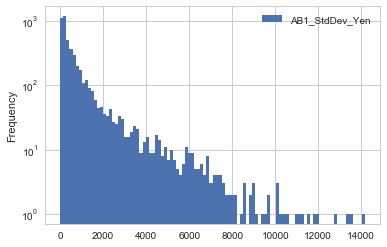

In [12]:
meta_df[meta_df[YEN] > 0.0][[YEN]].plot.hist(bins=100, 
                                             log=True)
plt.show()

In [13]:
meta_df['age_months'].value_counts()

4     4292
18    4085
6     1015
12     935
Name: age_months, dtype: int64

In [14]:
regions = meta_df[REGION].unique()
regions.sort()
regions

array(['AT_AUD', 'AT_CNU', 'AT_CTXsp', 'AT_ECT', 'AT_ENTI', 'AT_FB',
       'AT_FB_HY', 'AT_FB_TH', 'AT_HPd_CA1_slm', 'AT_HPd_CA1_so',
       'AT_HPd_CA1_sr', 'AT_HPd_CA2_slm', 'AT_HPd_CA2_so', 'AT_HPd_CA2_sr',
       'AT_HPd_CA3_slm', 'AT_HPd_CA3_slu', 'AT_HPd_CA3_so',
       'AT_HPd_CA3_sr', 'AT_HPd_DG_mo', 'AT_HPd_DG_po', 'AT_HPs_CA1_sp',
       'AT_HPs_CA2_sp', 'AT_HPs_CA3_sp', 'AT_HPs_DG_sp', 'AT_HY', 'AT_MB',
       'AT_OLF', 'AT_PERI', 'AT_PTL', 'AT_RSP', 'AT_SSp', 'AT_TE', 'AT_TH',
       'AT_VL', 'unknown'], dtype=object)

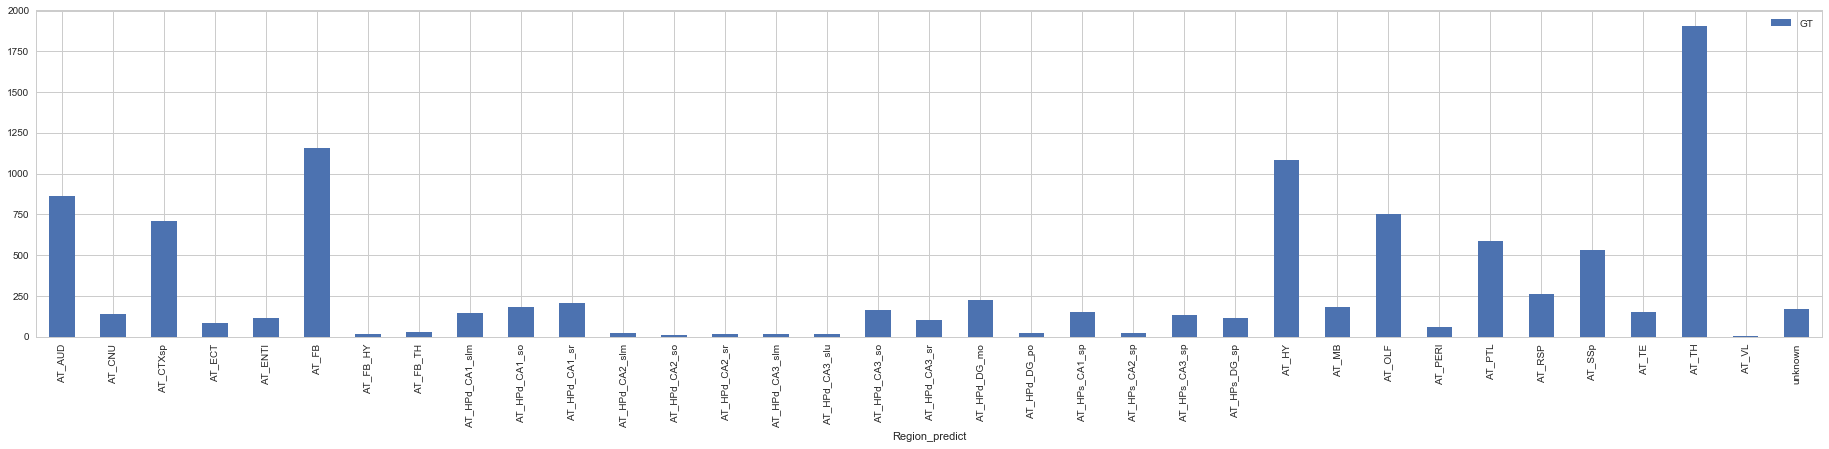

In [15]:
meta_df[[REGION, GT]].groupby(REGION).count().plot(kind='bar', figsize=(32,6))
plt.show()

## **Plaque pixel intensity StdDev Yen**

### **By age (months)**

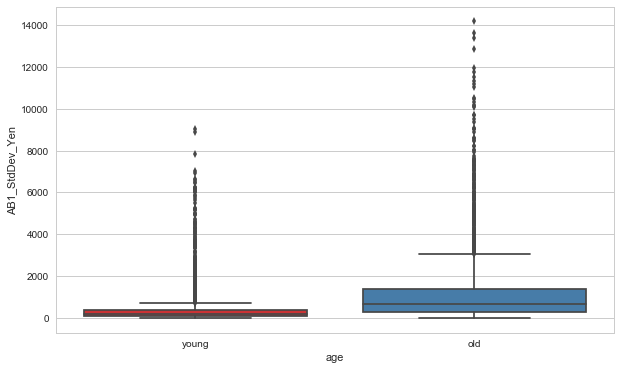

In [61]:
fig, ax = plt.subplots(figsize=(10, 6))

# ax.set(yscale="log")
data = meta_df[(meta_df['GT'] == 'KI')][[YEN, MONTHS, AGE]]
sns.boxplot(data=data, x=AGE, y=YEN, palette="Set1", dodge=True)

plt.show()

### **AB1 (StdDev Yen) By Region / Age in KI**

* https://stackoverflow.com/questions/40514921/ordering-boxplot-x-axis-in-seaborn

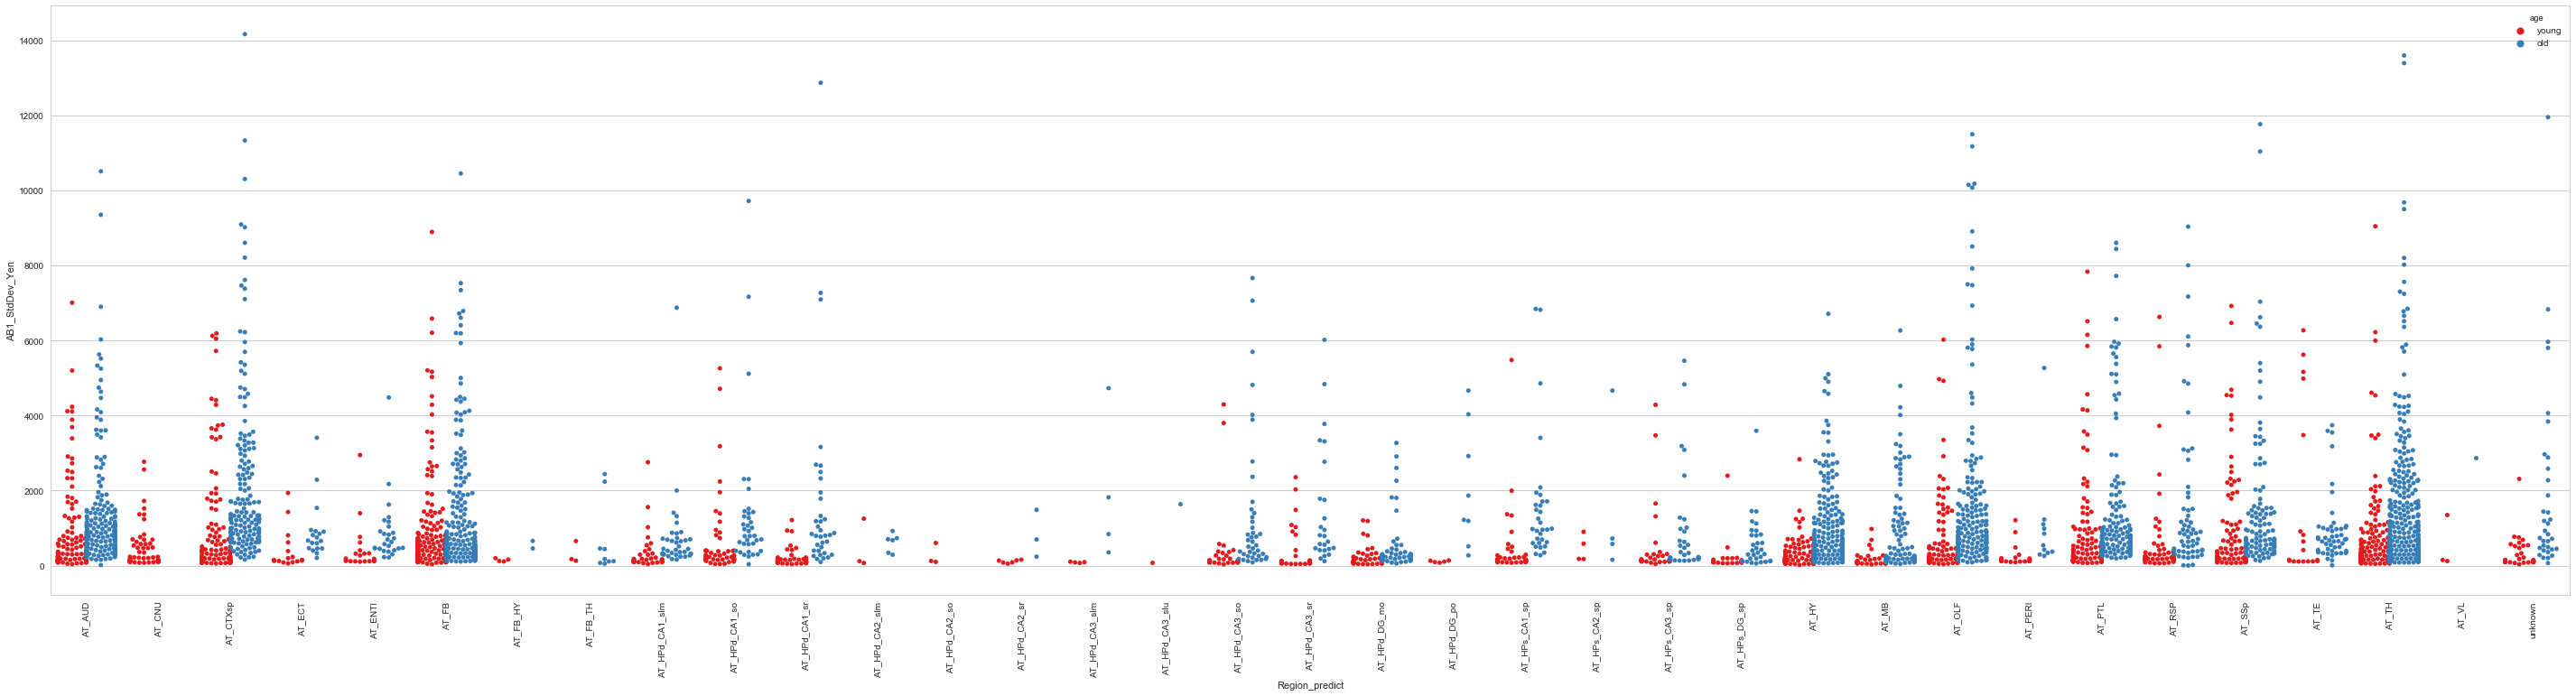

In [25]:
fig, ax = plt.subplots(figsize=(50, 12))

#data = meta_df[(meta_df['GT'] == 'KI') & (meta_df[YEN] < 4000)][[YEN, MONTHS, REGION, AGE]]
data = meta_df[(meta_df['GT'] == 'KI')][[YEN, MONTHS, REGION, AGE]]
g = sns.swarmplot(data=data, x=REGION, y=YEN, hue=AGE, palette="Set1", order=regions, dodge=True)
g.set_xticklabels(rotation=90, labels=regions)

plt.show()

In [26]:
data.describe()

,AB1_StdDev_Yen,age_months
count,5009.000000,5009.000000
mean,881.651610,10.638451
std,1444.236775,6.473870
min,3.499769,4.000000
25%,154.308193,4.000000
50%,329.837907,12.000000
75%,903.144838,18.000000
max,14161.168653,18.000000


## Cell Type distributions by Age and Genotype

In [53]:
def plot_dist_by_age_GT_swarm(meta_df, cell_type):
    fig, ax = plt.subplots(figsize=(100, 8))
    
    data = meta_df[[cell_type, REGION, AGE_GT]]
    g = sns.swarmplot(data=data, x=REGION, y=cell_type, hue=AGE_GT, palette="Set1", order=regions, dodge=True)
    g.set_xticklabels(rotation=90, labels=regions)
    
    plt.show()

In [54]:
def plot_dist_by_age_GT_box(meta_df, cell_type):
    fig, ax = plt.subplots(figsize=(100, 8))
    
    data = meta_df[[cell_type, REGION, AGE_GT]]
    g = sns.boxplot(data=data, x=REGION, y=cell_type, hue=AGE_GT, palette="Set1", order=regions, dodge=True)
    g.set_xticklabels(rotation=90, labels=regions)
    
    plt.show()

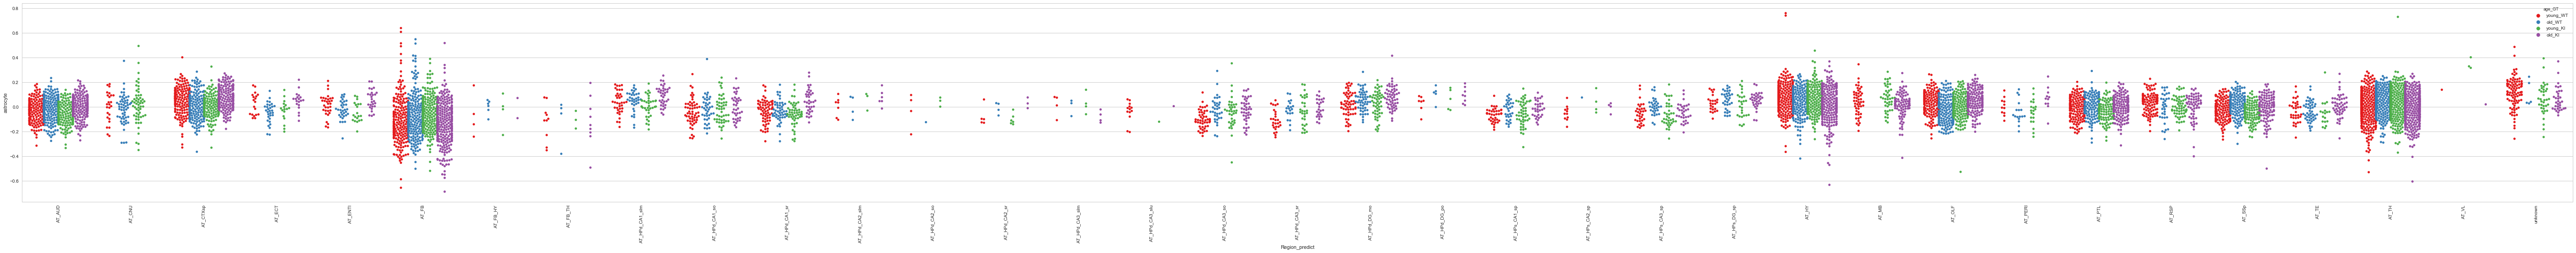

In [55]:
plot_dist_by_age_GT_swarm(meta_df, ASTROCYTE)

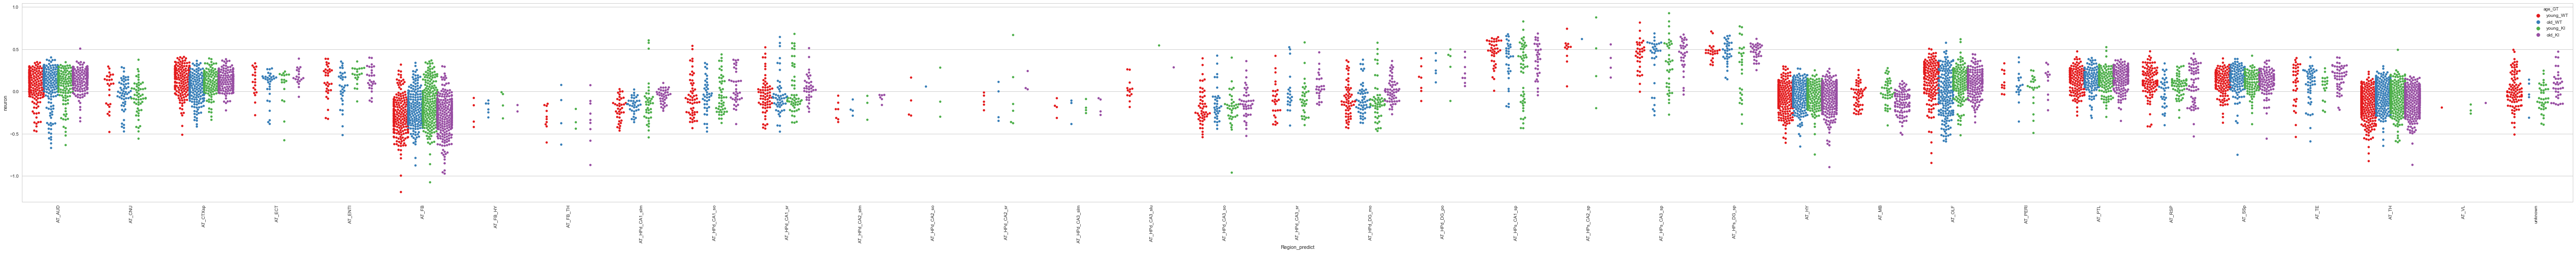

In [43]:
plot_dist_by_age_GT(meta_df, NEURON)